In [1]:
import os
import scipy.io
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import lightgbm as lgb
import geohash2 as geo

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error as mse

import warnings 
warnings.filterwarnings('ignore') 
pd.set_option('display.max_rows',1000) 
pd.set_option('display.max_columns',1000)

plt.rcParams['figure.figsize'] = (30, 15)

In [2]:
test_data = pd.read_csv('E:/traindata/B/testData 0626.csv')
portlist = test_data.TRANSPORT_TRACE.unique().tolist()
boatlist = test_data.vesselMMSI.unique().tolist()

In [43]:
dd = pd.read_csv('E:/traindata/source/train_A.csv')
l = dd.loc[dd.vesselMMSI.isin(boatlist)].loadingOrder.unique()
l

array(['AA191175561416', 'AA236935066990', 'AA642567891255',
       'AB494971654341', 'AB503189741912', 'AC498331004901',
       'AD205574515833', 'AD995240210737', 'AD996489556118',
       'AF291281245513', 'AF641280380594', 'AF842018574399',
       'AF862663000281', 'AG424688892904', 'AH611886522181',
       'AH734641844883', 'AH861147242321', 'AI277413217792',
       'AI989403658628', 'AI990380503724', 'AJ600775896968',
       'AJ624244686836', 'AJ916634114427', 'AJ978747126294',
       'AK398507576281', 'AK980230261389', 'AL530484821704',
       'AL660217152867', 'AL692388612232', 'AM840045695221',
       'AN160245196123', 'AN738504256661', 'AN910923566249',
       'AO287854813767', 'AP254924452907', 'AP755627449920',
       'AP974946084069', 'AQ141450710761', 'AQ653041250119',
       'AQ749153560304', 'AR707049810768', 'AS316641737557',
       'AS540010708999', 'AT327564663210', 'AT407815152607',
       'AT508096676515', 'AT747758879481', 'AU242086092228',
       'AU265023696929',

In [4]:
filelist = ['train_{}.csv'.format(i) for i in ['B','C','D','E','F','G','H','I','J','K','L','M',
                                                'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']]

# filelist = ['train_A.csv']
for file in tqdm(filelist):
    srcPath = 'E:/traindata/source/' + file
    train_data = pd.read_csv(srcPath)
    train_data = train_data.drop(columns=['Unnamed: 0'])
#     train_data.TRANSPORT_TRACE = train_data.TRANSPORT_TRACE.fillna(method='bfill')
    train_data = train_data.loc[train_data['TRANSPORT_TRACE'].isin(portlist)]
    train_data = train_data.reset_index(drop=True)
    train_data.to_csv('E:/traindata/D/alldata.csv',index=False,mode='a',header=0)#

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:23<00:00, 10.55s/it]


In [5]:
train_data = pd.read_csv('E:/traindata/D/alldata.csv')
train_data = train_data.drop(columns=['vesselNextport','vesselNextportETA','vesselStatus','vesselDatasource'])
train_data = train_data.sort_values(by=['loadingOrder','timestamp'],ignore_index=1)
train_data.to_csv('E:/traindata/D/alldata.csv',index=0)

In [7]:
train_data.loadingOrder.nunique()

768

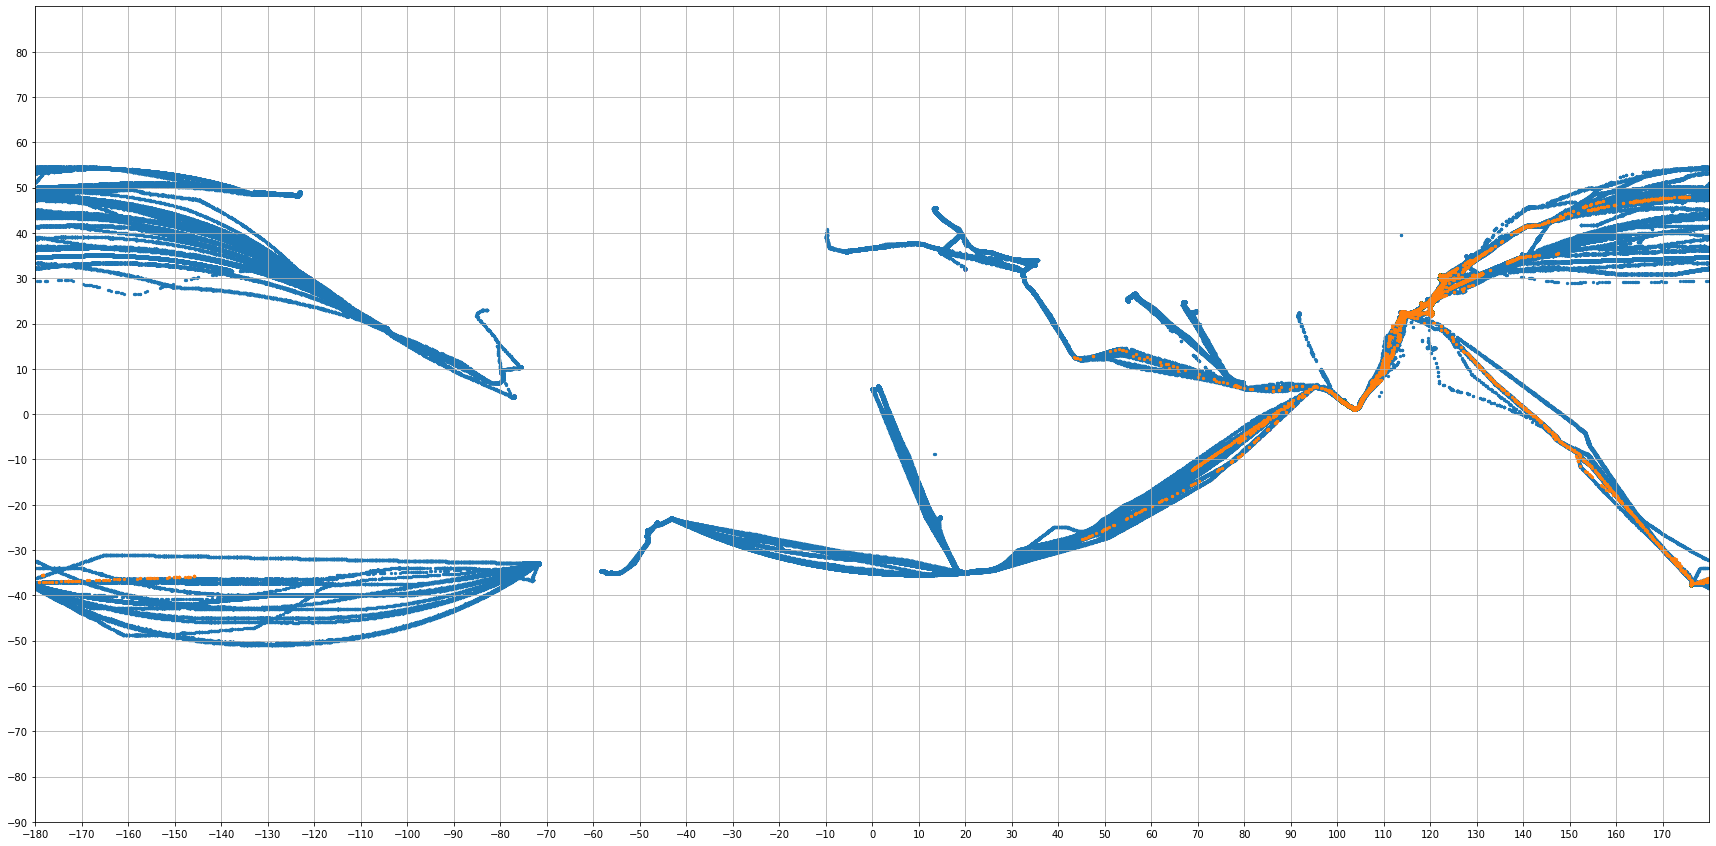

In [10]:
plt.axis([-180,180,-90,90])
plt.grid()
plt.xticks(np.arange(-180,180,10))
plt.yticks(np.arange(-90,90,10))
plt.scatter(train_data.longitude,train_data.latitude,s=5)
plt.scatter(test_data.longitude,test_data.latitude,s=5)

In [108]:
srcDATAPATH = 'E:/traindata/test/testData 0626.csv'
# srcDATAPATH = 'E:/traindata/D/alldata.csv'
CHUNKSIZE = 10000
train_data = pd.read_csv(srcDATAPATH,chunksize=CHUNKSIZE)
geolist = []
for chunk in tqdm(train_data):
#     data = get_data(chunk,mode='train')
    lat = chunk.latitude.tolist()
    lon = chunk.longitude.tolist()
    arr = np.array([lat,lon])
    for i in range(len(chunk)):
        geolist.append((geo.encode(arr[0,i],arr[1,i],5)))
#     geoseries = pd.Series(geolist)
geoData = pd.read_csv(srcDATAPATH)
# geoData.insert(5, 'port1geo', geolist)
geoData['geo'] = geolist
geoData = geoData.reset_index(drop=1)
geoData.head(10)

4it [00:00,  8.20it/s]


,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,geo
0,AE223035353902,2019-07-03T21:16:48.000Z,120.093858,22.581320,24,29070.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2k
1,AE223035353902,2019-07-03T21:34:48.000Z,120.035707,22.617522,25,34550.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2e
2,AE223035353902,2019-07-03T21:51:18.000Z,119.981800,22.658465,32,30160.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2f
3,AE223035353902,2019-07-03T21:54:18.000Z,119.970845,22.668688,33,33540.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2f
4,AE223035353902,2019-07-03T22:11:08.000Z,119.953628,22.756897,36,35140.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj33
5,AE223035353902,2019-07-03T22:21:08.000Z,119.946252,22.812477,37,35300.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj3c
6,AE223035353902,2019-07-03T23:21:18.000Z,119.923585,23.164680,40,35970.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj7b
7,AE223035353902,2019-07-03T23:23:48.000Z,119.923615,23.179950,40,35900.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj7b
8,AE223035353902,2019-07-03T23:57:18.000Z,119.919883,23.388572,42,35930.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsjm0
9,AE223035353902,2019-07-04T01:05:38.000Z,119.995410,23.831675,43,1690.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsjrd


In [110]:
# geodf = geoData.drop_duplicates(['loadingOrder','geo'],keep='first')
geodf = geoData
geodf = geodf.reset_index(drop=1)

# geodf.TRANSPORT_TRACE = geodf.TRANSPORT_TRACE.astype(str)
# portlist = geodf['TRANSPORT_TRACE'].unique().tolist()
# droptracelist = []
# for ls in portlist:
#     tr = ls.split('-')
#     if len(tr) == 1 :
#         droptracelist.append(ls)
# geodf = geodf[~geodf['TRANSPORT_TRACE'].isin(droptracelist)].reset_index(drop=1)

geodf['port0name'] = geodf['TRANSPORT_TRACE'].apply(lambda x: x.split('-')[0])
geodf['port1name'] = geodf['TRANSPORT_TRACE'].apply(lambda x: x.split('-')[1])
geodf.to_csv('E:/traindata/D/testdata.csv',index=False)
geodf.head(10)

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,geo,port0name,port1name
0,AE223035353902,2019-07-03T21:16:48.000Z,120.093858,22.581320,24,29070.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2k,CNYTN,MXZLO
1,AE223035353902,2019-07-03T21:34:48.000Z,120.035707,22.617522,25,34550.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2e,CNYTN,MXZLO
2,AE223035353902,2019-07-03T21:51:18.000Z,119.981800,22.658465,32,30160.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2f,CNYTN,MXZLO
3,AE223035353902,2019-07-03T21:54:18.000Z,119.970845,22.668688,33,33540.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj2f,CNYTN,MXZLO
4,AE223035353902,2019-07-03T22:11:08.000Z,119.953628,22.756897,36,35140.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj33,CNYTN,MXZLO
5,AE223035353902,2019-07-03T22:21:08.000Z,119.946252,22.812477,37,35300.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj3c,CNYTN,MXZLO
6,AE223035353902,2019-07-03T23:21:18.000Z,119.923585,23.164680,40,35970.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj7b,CNYTN,MXZLO
7,AE223035353902,2019-07-03T23:23:48.000Z,119.923615,23.179950,40,35900.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsj7b,CNYTN,MXZLO
8,AE223035353902,2019-07-03T23:57:18.000Z,119.919883,23.388572,42,35930.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsjm0,CNYTN,MXZLO
9,AE223035353902,2019-07-04T01:05:38.000Z,119.995410,23.831675,43,1690.0,OIEQNT,C2075927370,2019/07/02 04:12:48,CNYTN-MXZLO,wsjrd,CNYTN,MXZLO


In [ ]:
geodf.groupby('loadingOrder')['timestamp'].count()

In [2]:
def get_data(df, mode='train'):
    assert mode=='train' or mode=='test'
    
#     if mode=='train':
    if mode=='test':
        df['temp_timestamp'] = df['timestamp']
        df['onboardDate'] = pd.to_datetime(df['onboardDate'], infer_datetime_format=True)    
    df['loadingOrder'] = df['loadingOrder'].astype(str)
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
    df['longitude'] = df['longitude'].astype(float)    
    df['longitude'] = round(df['longitude'],6)
    df['latitude'] = df['latitude'].astype(float)
    df['latitude'] = round(df['latitude'],6) 
    df['speed'] = df['speed'].astype(float)
    df['direction'] = df['direction'].astype(float)
    return df

In [134]:
trainDataPath1 = 'E:/traindata/D/alldata_geo5.csv'
testDataPath1 = 'E:/traindata/D/testData_geo5.csv'

traindata1 = pd.read_csv(trainDataPath1)
testData1 = pd.read_csv(testDataPath1)

t1 = traindata1.loc[(traindata1.longitude<-70)  & (traindata1.longitude>-180) & (traindata1.latitude<60)
                    & (traindata1.latitude>0) ].index.tolist()#.loadingOrder.unique().tolist()

t2 = traindata1.loc[(traindata1.longitude<42)  & (traindata1.longitude>-60) & (traindata1.latitude<50)
                    & (traindata1.latitude>-40) ].index.tolist()

t3 = traindata1.loc[(traindata1.longitude<-70)  & (traindata1.longitude>-145) & (traindata1.latitude<-30)
                    & (traindata1.latitude>-55) ].index.tolist()

t4 = traindata1.loc[(traindata1.longitude<180)  & (traindata1.longitude>148) & (traindata1.latitude<44)
                    & (traindata1.latitude>25) ].index.tolist()

# t5 = traindata1.loc[(traindata1.longitude<180)  & (traindata1.longitude>148) & (traindata1.latitude<43)
#                     & (traindata1.latitude>25) ].index.tolist()


traindata2 = traindata1[~traindata1.index.isin(t1)]
traindata3 = traindata2[~traindata2.index.isin(t2)]
traindata4 = traindata3[~traindata3.index.isin(t3)]
traindata5 = traindata4[~traindata4.index.isin(t4)]


In [132]:
traindata5.to_csv('E:/traindata/D/cutdata_geo5.csv',index=0)

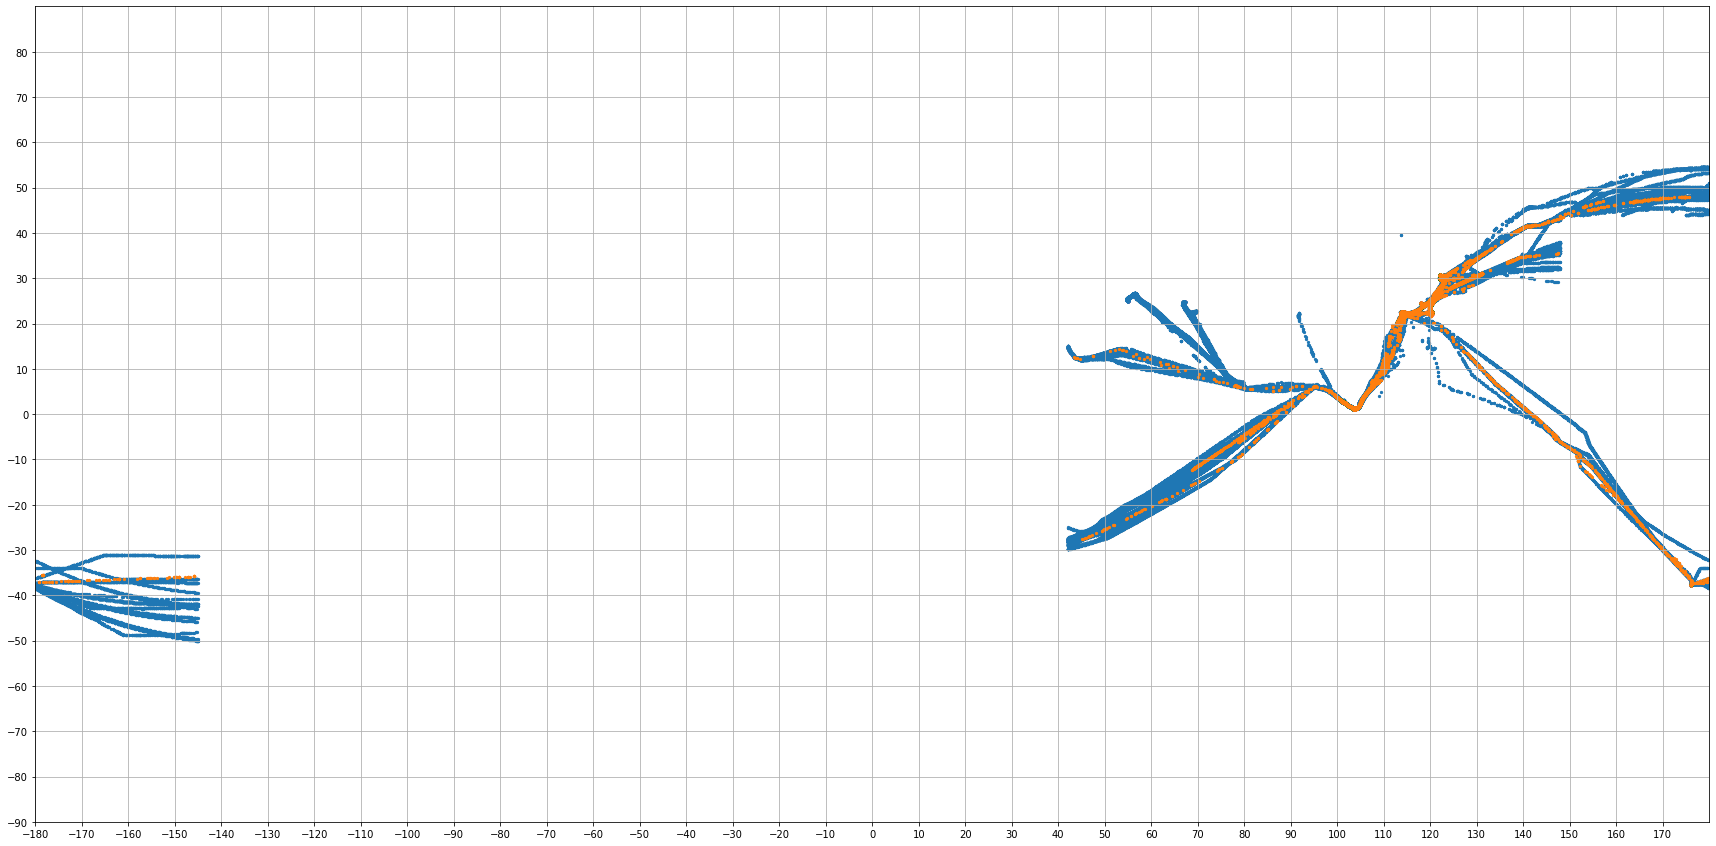

In [135]:

plt.axis([-180,180,-90,90])
plt.grid()
plt.xticks(np.arange(-180,180,10))
plt.yticks(np.arange(-90,90,10))
plt.scatter(traindata5.longitude,traindata5.latitude,s=5)
plt.scatter(test_data.longitude,test_data.latitude,s=5)

In [149]:
tt = pd.read_csv('E:/traindata/D/cutdata_geo5.csv')
tr_ct = tt['loadingOrder'].unique()
sampdf = pd.DataFrame()
for order in tqdm(tr_ct):
    gf = tt.loc[tt['loadingOrder']==order]
    gf = gf[:int(len(gf)*0.6)]
    sampdf = sampdf.append(gf)
sampdf = sampdf.reset_index(drop=1)
sampdf.head(10)

100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:41<00:00, 18.57it/s]


,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,geo,port0name,port1name
0,AA191175561416,OIEQNT,2019-01-28T16:12:59.000Z,114.260392,22.571047,Y7540547327,0,12670,CNYTN-MXZLO,ws122,CNYTN,MXZLO
1,AA191175561416,OIEQNT,2019-01-29T15:19:10.000Z,114.305837,22.562520,Y7540547327,23,8580,CNYTN-MXZLO,ws123,CNYTN,MXZLO
2,AA191175561416,OIEQNT,2019-01-29T15:30:32.000Z,114.351468,22.550587,Y7540547327,27,10800,CNYTN-MXZLO,ws126,CNYTN,MXZLO
3,AA191175561416,OIEQNT,2019-01-29T15:39:38.000Z,114.388555,22.537042,Y7540547327,26,13090,CNYTN-MXZLO,ws124,CNYTN,MXZLO
4,AA191175561416,OIEQNT,2019-01-29T15:43:25.000Z,114.400715,22.526685,Y7540547327,27,13620,CNYTN-MXZLO,ws125,CNYTN,MXZLO
5,AA191175561416,OIEQNT,2019-01-29T15:55:01.000Z,114.427835,22.499337,Y7540547327,24,13770,CNYTN-MXZLO,wecrg,CNYTN,MXZLO
6,AA191175561416,OIEQNT,2019-01-29T15:59:26.000Z,114.442310,22.484577,Y7540547327,16,14420,CNYTN-MXZLO,wecru,CNYTN,MXZLO
7,AA191175561416,OIEQNT,2019-01-29T16:21:50.000Z,114.480637,22.410043,Y7540547327,31,15440,CNYTN-MXZLO,wecrm,CNYTN,MXZLO
8,AA191175561416,OIEQNT,2019-01-29T16:35:44.000Z,114.526663,22.357553,Y7540547327,35,12990,CNYTN-MXZLO,wecrn,CNYTN,MXZLO
9,AA191175561416,OIEQNT,2019-01-29T16:46:55.000Z,114.567383,22.331025,Y7540547327,35,12500,CNYTN-MXZLO,wecrp,CNYTN,MXZLO


In [150]:
sampdf.to_csv('E:/traindata/D/cutdata_geo5_6.csv',index=0)

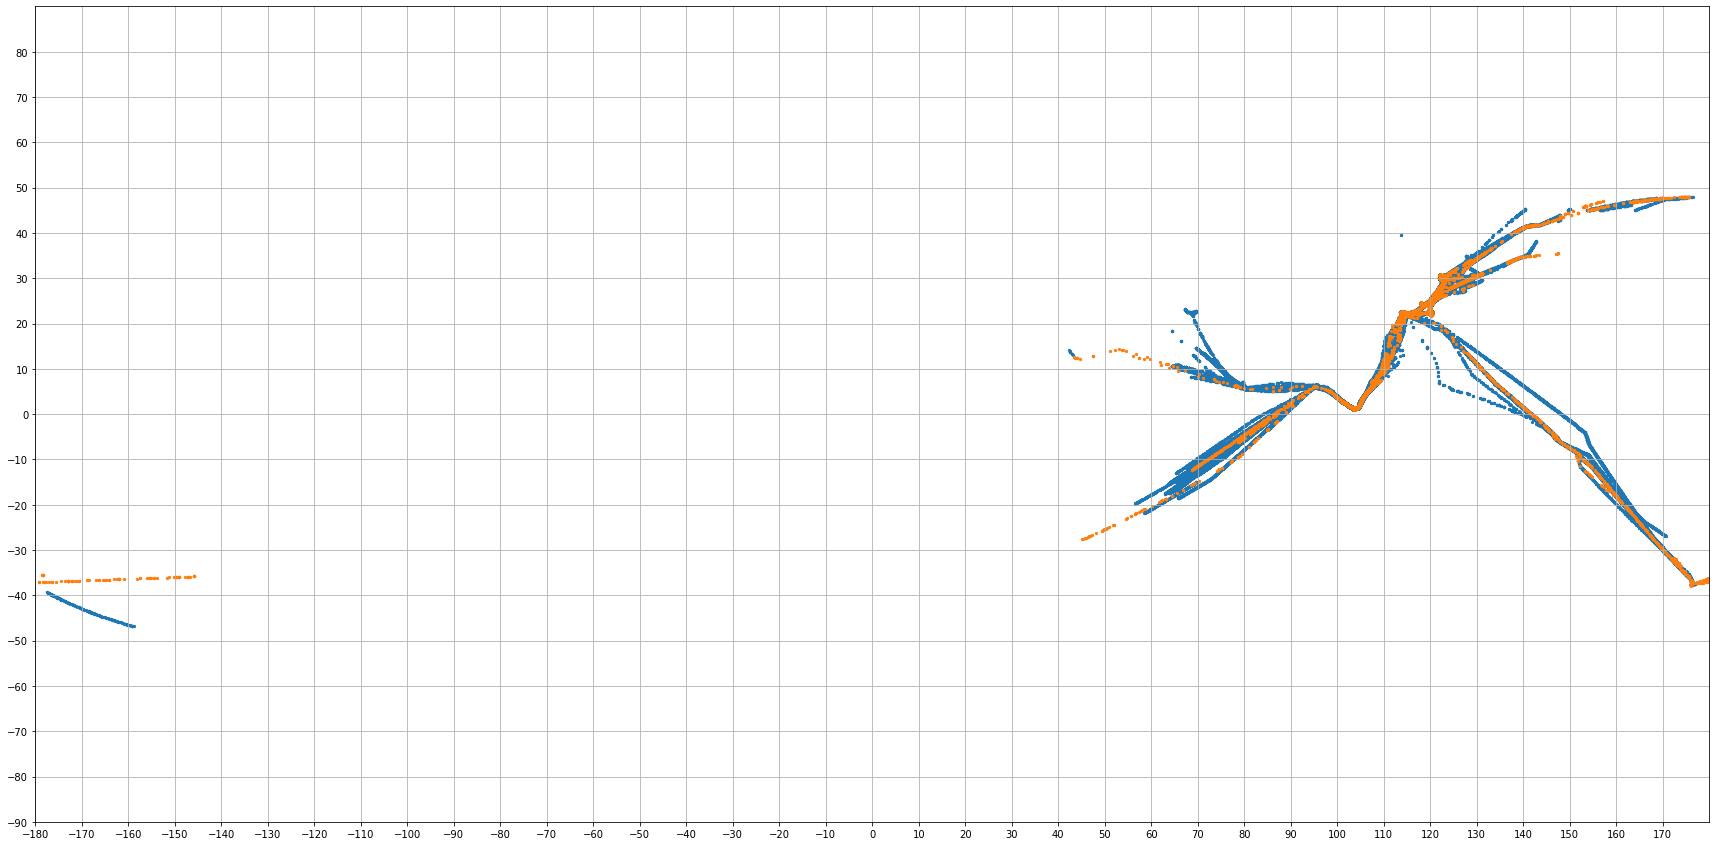

In [151]:
plt.axis([-180,180,-90,90])
plt.grid()
plt.xticks(np.arange(-180,180,10))
plt.yticks(np.arange(-90,90,10))
plt.scatter(sampdf.longitude,sampdf.latitude,s=5)
plt.scatter(test_data.longitude,test_data.latitude,s=5)

In [112]:
test_data = pd.read_csv('E:/traindata/B/testData 0626.csv')
test_data.groupby('loadingOrder')['timestamp'].count()

loadingOrder
AE223035353902     215
AE255175252207      42
AJ338174323933      54
BP352489313005     197
CJ649212973636     156
CM247448368157     734
CX921020302440     106
CY610195685233     201
DN799599926798      52
EF427213883396      56
EH267022831344      78
EH417316823657      29
EO389054510734      44
EP955322386383      65
ES509695023954      10
ES859495565412      23
FB514237413831     109
FC483811239672       8
FC717660279538     390
FM949372341953      48
FQ914057883235      23
FR946269565342      25
FT251830039061     296
FU680644019317      55
FU963630646772     280
FX658315757892      77
GA887308394758      84
GB519547320123      95
GB583887469604      18
GB883144830650     110
GM373318338848     165
GN416043321255      63
GO358732747064      24
GP961997210316      29
HB691160735030      34
HE273820450227     110
HJ246261379392     317
HM822520935334      35
HO283604623948     809
HQ298919518932     166
HS534528541188      94
HV119475836181      78
HV544902512699     46

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,geo,port0name,port1name,onboardDate,temp_timestamp
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,114.260392,22.571047,Y7540547327,0.0,12670.0,CNYTN-MXZLO,ws122,CNYTN,MXZLO,NaT,NaN
1,AA191175561416,OIEQNT,2019-01-29 15:19:10+00:00,114.305837,22.562520,Y7540547327,23.0,8580.0,CNYTN-MXZLO,ws123,CNYTN,MXZLO,NaT,NaN
2,AA191175561416,OIEQNT,2019-01-29 15:30:32+00:00,114.351468,22.550587,Y7540547327,27.0,10800.0,CNYTN-MXZLO,ws126,CNYTN,MXZLO,NaT,NaN
3,AA191175561416,OIEQNT,2019-01-29 15:39:38+00:00,114.388555,22.537042,Y7540547327,26.0,13090.0,CNYTN-MXZLO,ws124,CNYTN,MXZLO,NaT,NaN
4,AA191175561416,OIEQNT,2019-01-29 15:43:25+00:00,114.400715,22.526685,Y7540547327,27.0,13620.0,CNYTN-MXZLO,ws125,CNYTN,MXZLO,NaT,NaN
5,AA191175561416,OIEQNT,2019-01-29 15:55:01+00:00,114.427835,22.499337,Y7540547327,24.0,13770.0,CNYTN-MXZLO,wecrg,CNYTN,MXZLO,NaT,NaN
6,AA191175561416,OIEQNT,2019-01-29 15:59:26+00:00,114.442310,22.484577,Y7540547327,16.0,14420.0,CNYTN-MXZLO,wecru,CNYTN,MXZLO,NaT,NaN
7,AA191175561416,OIEQNT,2019-01-29 16:21:50+00:00,114.480637,22.410043,Y7540547327,31.0,15440.0,CNYTN-MXZLO,wecrm,CNYTN,MXZLO,NaT,NaN
8,AA191175561416,OIEQNT,2019-01-29 16:35:44+00:00,114.526663,22.357553,Y7540547327,35.0,12990.0,CNYTN-MXZLO,wecrn,CNYTN,MXZLO,NaT,NaN
9,AA191175561416,OIEQNT,2019-01-29 16:46:55+00:00,114.567383,22.331025,Y7540547327,35.0,12500.0,CNYTN-MXZLO,wecrp,CNYTN,MXZLO,NaT,NaN


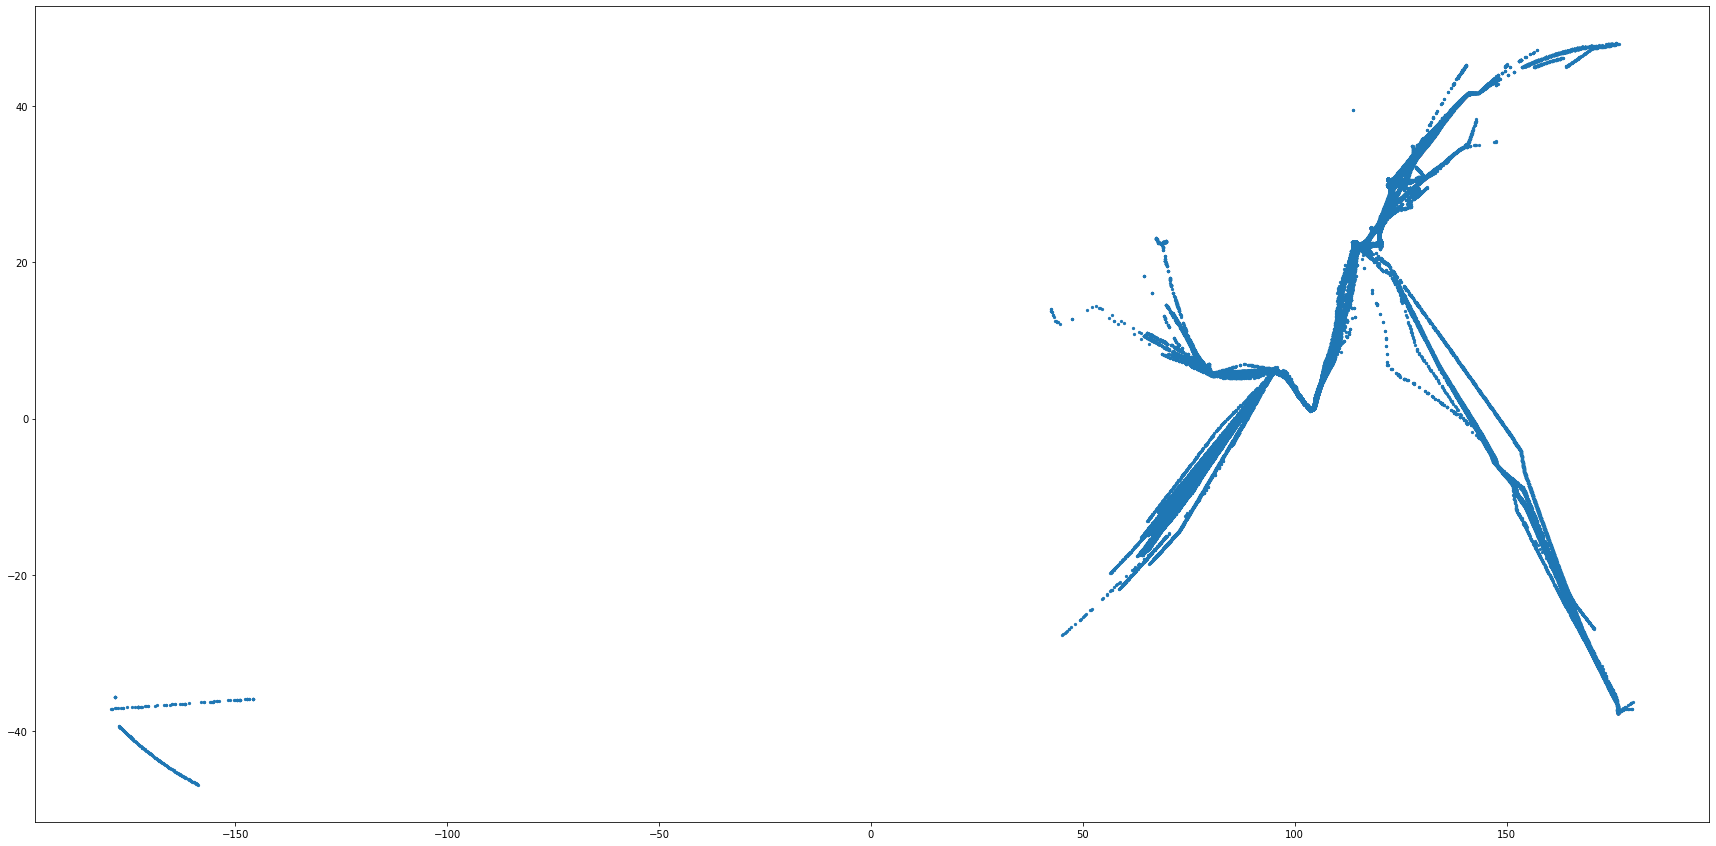

In [152]:
trainDataPath = 'E:/traindata/D/cutdata_geo5_6.csv'
testDataPath = 'E:/traindata/D/testdata.csv'

traindata = pd.read_csv(trainDataPath)
testData = pd.read_csv(testDataPath)

traindata = get_data(traindata,mode='train')
testData = get_data(testData,mode='test')

traindata = pd.concat([traindata,testData], ignore_index=True)

trajectories = traindata[['loadingOrder','longitude','latitude']]
trajectories['lat_lon'] = list(zip(traindata['longitude'],traindata['latitude']))
trajectories = trajectories[['loadingOrder','lat_lon']]

order_index = list(trajectories['loadingOrder'].unique())
seg_trips = []
for index in order_index:
    trip_test = trajectories[trajectories['loadingOrder'] == index]
    trips = list(trip_test['lat_lon'].tolist())
    seg_trips.append(trips)
with open('E:/traindata/D/segment_trajectories_geo5_test','wb') as fp:
    pickle.dump(seg_trips,fp)

plt.scatter(traindata['longitude'],traindata['latitude'],s=5)
traindata.head(10)

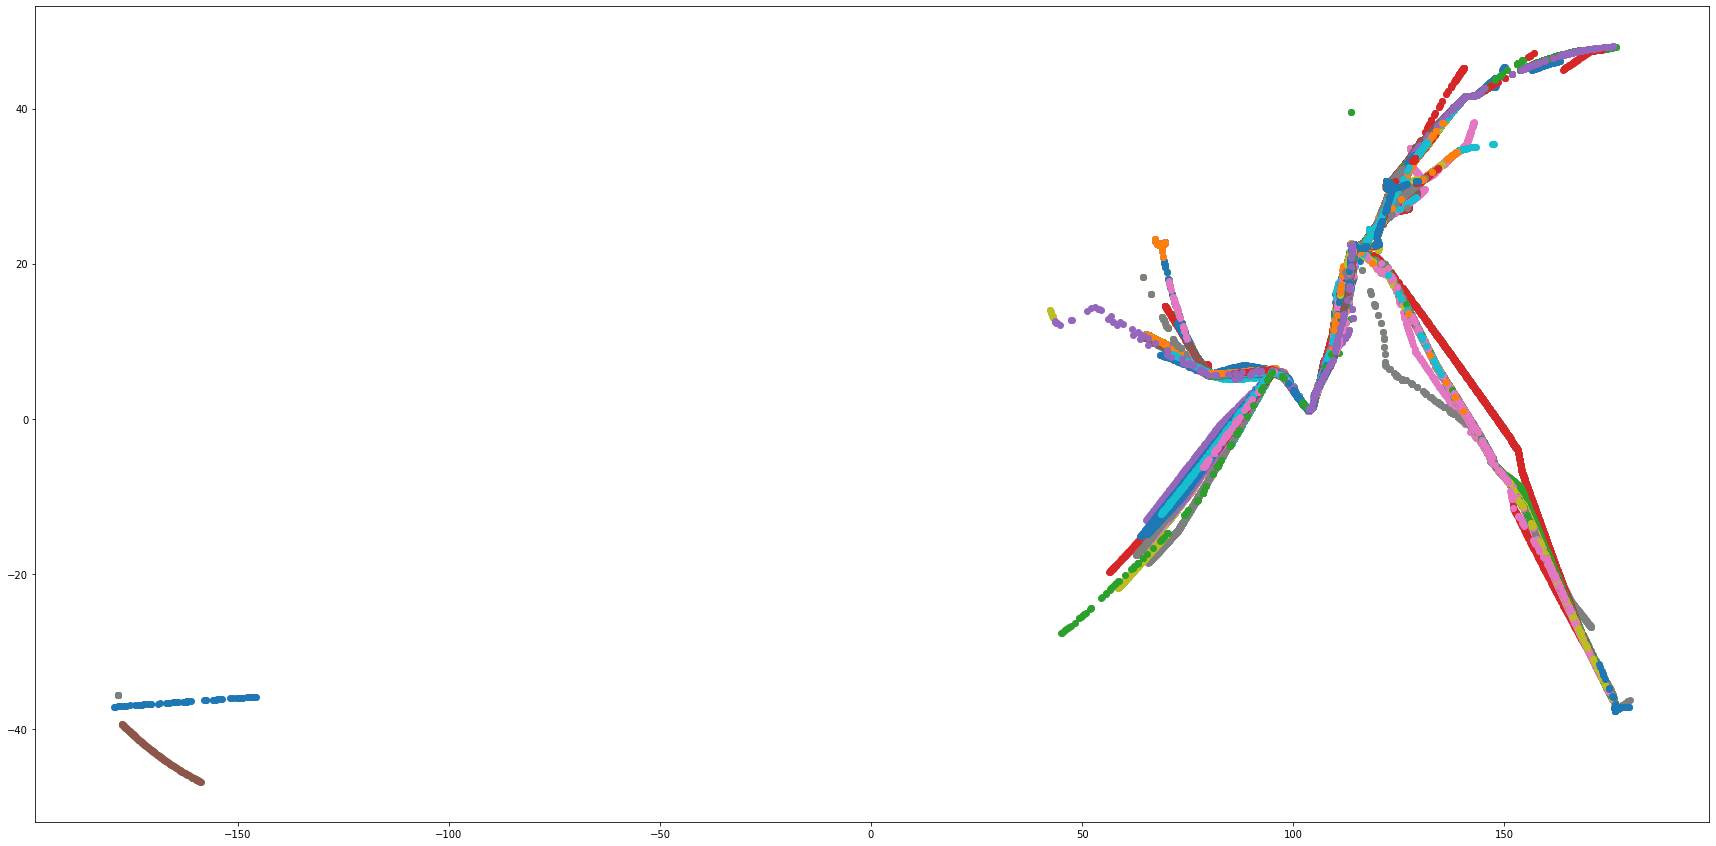

In [153]:
with open('E:/traindata/D/segment_trajectories_geo5_test','rb') as fp:      
    trip_lst = pickle.load(fp)

trip_lst_np = [] 
for i in trip_lst:     
    new_strut = np.asarray(i)     
    trip_lst_np.append(new_strut)  
for traj in trip_lst_np:     
    plt.scatter(traj[:, 0], traj[:, 1])

In [154]:
def hausdorff(u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(trip_lst_np)
D = np.zeros((traj_count, traj_count)) 
#loop through each trajectory and calcuate the distnace to all the other trajectories
for i in tqdm(range(traj_count)):
    for j in range(i + 1, traj_count):
        distance = hausdorff(trip_lst_np[i], trip_lst_np[j])
        D[i, j] = distance
        D[j, i] = distance
np.save('E:/traindata/D/D_matrix_geo5_test.npy',D)

100%|████████████████████████████████████████████████████████████████████████████████| 985/985 [11:30<00:00,  1.43it/s]


In [155]:

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [156]:
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.scatter(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.scatter(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)],s=5)
    plt.show()

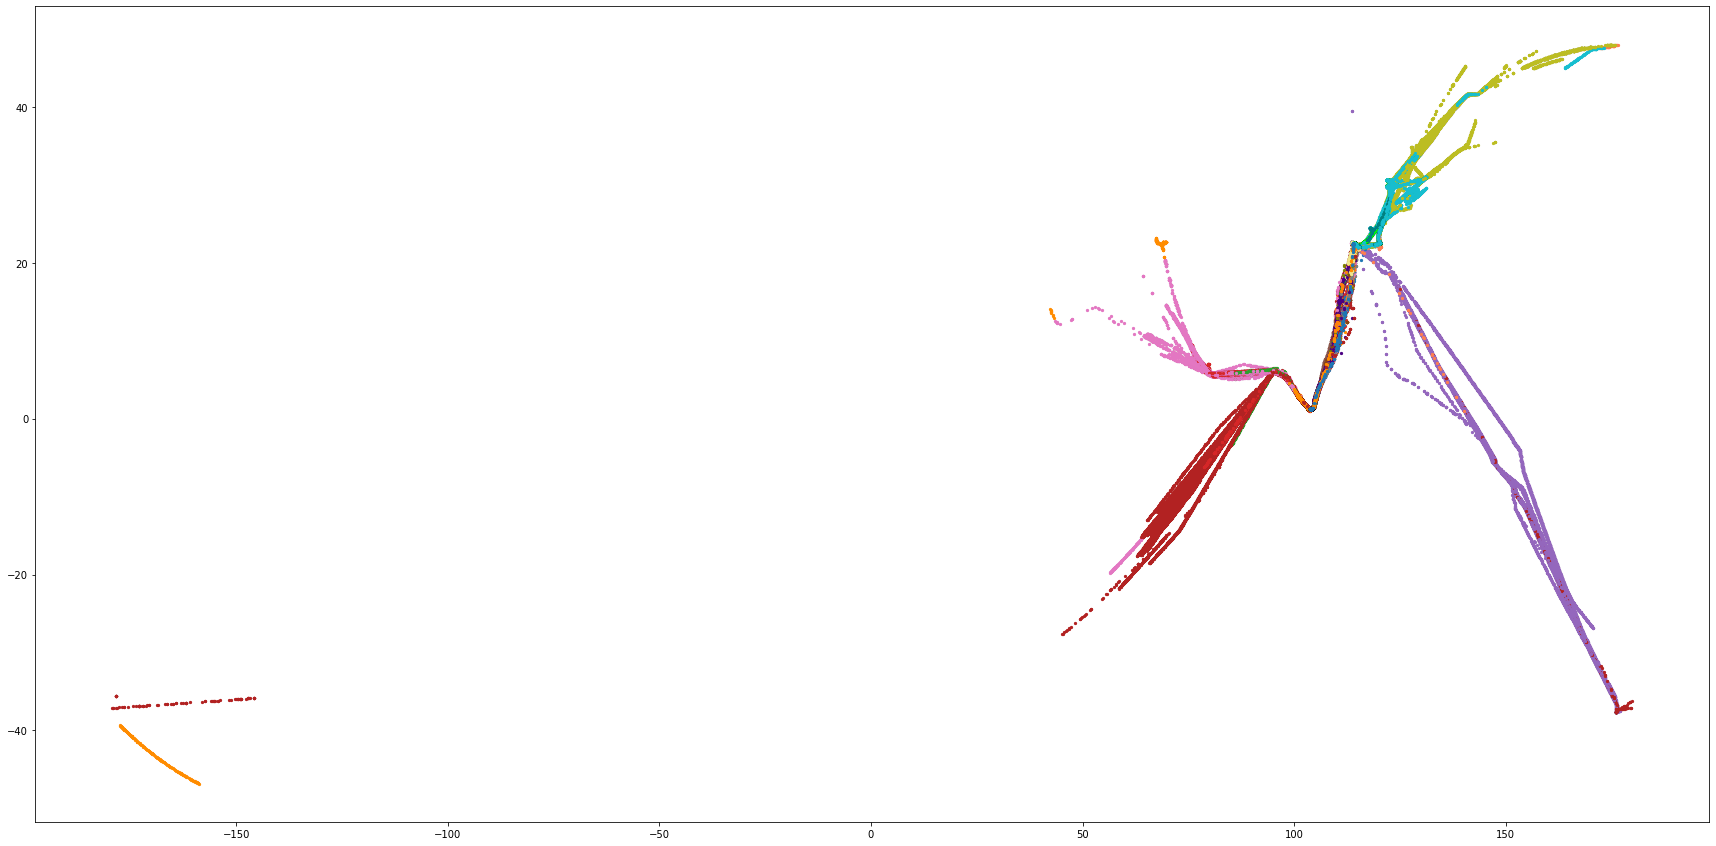

In [157]:
E = np.load('E:/traindata/D/D_matrix_geo5_test.npy')
traj_count = len(trip_lst_np)
k = 20
medoid_center_lst, cluster2index_lst = kMedoids(E, k)  
cluster_lst = np.empty((traj_count,), dtype=int)  
for cluster in cluster2index_lst:     
    cluster_lst[cluster2index_lst[cluster]] = cluster

plot_cluster(trip_lst_np,cluster_lst)

In [158]:
cluster_lst

array([ 9, 12,  5, 12,  3,  4, 10,  3,  6,  3, 10,  7,  9,  7,  3,  6,  8,
        7,  7,  3,  8,  6,  3,  4,  3, 12,  4,  5,  2,  6,  8,  8,  3, 12,
        5,  8,  3,  4,  9,  8,  9,  6, 13, 12,  0, 18,  8,  8, 12,  4, 10,
        0,  6,  8,  6,  8,  6, 15,  4,  8, 10,  8, 12,  4,  1,  7,  1,  9,
        3,  6,  6,  3, 17,  2, 12,  6,  8,  4,  8, 15,  8,  1,  6, 13, 10,
        9,  3,  6,  3, 10, 15,  9,  1,  8,  0,  8,  9,  6,  7,  8,  5,  5,
        9, 13,  7,  3,  2,  2, 17, 15,  3, 11,  2,  4,  2,  2,  5,  3,  3,
        1,  9,  3,  6,  7, 12,  6, 15, 12,  6,  7,  0,  2,  4, 12,  5, 12,
        3,  3, 12,  7,  4, 13, 12,  6,  9,  7, 12,  3,  6,  0,  3,  2,  3,
        1, 18,  2,  3,  8,  9,  2,  9, 10,  4,  1,  6,  3,  9,  3,  6,  5,
        0,  6,  5,  4,  9,  7,  6, 15,  4,  8,  0, 12,  8,  1, 12,  7,  5,
        4,  3,  3, 12, 10,  4,  6, 12,  6, 12,  2,  3, 12,  3,  5,  5,  0,
        5,  4, 15,  1,  3,  8,  5, 12,  7,  6,  1,  1,  9,  4,  9, 10, 10,
        2, 15,  5, 10,  3

In [159]:
groupdata = trajectories['loadingOrder'].unique()
groupdata = pd.DataFrame(groupdata,columns=['loadingOrder'])
groupdata['trace'] = cluster_lst
tradata = traindata.merge(groupdata,on='loadingOrder',how='left')
tradata

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,geo,port0name,port1name,onboardDate,temp_timestamp,trace
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,114.260392,22.571047,Y7540547327,0.0,12670.0,CNYTN-MXZLO,ws122,CNYTN,MXZLO,NaT,NaN,9
1,AA191175561416,OIEQNT,2019-01-29 15:19:10+00:00,114.305837,22.562520,Y7540547327,23.0,8580.0,CNYTN-MXZLO,ws123,CNYTN,MXZLO,NaT,NaN,9
2,AA191175561416,OIEQNT,2019-01-29 15:30:32+00:00,114.351468,22.550587,Y7540547327,27.0,10800.0,CNYTN-MXZLO,ws126,CNYTN,MXZLO,NaT,NaN,9
3,AA191175561416,OIEQNT,2019-01-29 15:39:38+00:00,114.388555,22.537042,Y7540547327,26.0,13090.0,CNYTN-MXZLO,ws124,CNYTN,MXZLO,NaT,NaN,9
4,AA191175561416,OIEQNT,2019-01-29 15:43:25+00:00,114.400715,22.526685,Y7540547327,27.0,13620.0,CNYTN-MXZLO,ws125,CNYTN,MXZLO,NaT,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243730,ZZ524449869421,BHSOUA,2020-03-17 04:02:38+00:00,103.776707,1.252897,P2595193878,6.0,32320.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:02:38.000Z,0
243731,ZZ524449869421,BHSOUA,2020-03-17 04:03:18+00:00,103.776312,1.253418,P2595193878,6.0,32340.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:03:18.000Z,0
243732,ZZ524449869421,BHSOUA,2020-03-17 04:05:18+00:00,103.775175,1.254865,P2595193878,5.0,32030.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:05:18.000Z,0
243733,ZZ524449869421,BHSOUA,2020-03-17 04:05:58+00:00,103.774803,1.255285,P2595193878,5.0,31940.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:05:58.000Z,0


In [21]:
traa = pd.read_csv('E:/traindata/D/alldata.csv')
traa.timestamp = pd.to_datetime(traa['timestamp'], infer_datetime_format=True)
lab = traa.groupby('loadingOrder')['timestamp'].agg(mmax='max',mmin='min')
lab['label'] = (lab['mmax']-lab['mmin']).dt.total_seconds() / 3600
lab = lab.reset_index()
lb = lab[['loadingOrder','label']]
lb

,loadingOrder,label
0,AA191175561416,626.443333
1,AA681773043065,104.654722
2,AB283635056094,99.781944
3,AB309086787273,115.129167
4,AC188113754775,428.877222
5,AC458999327091,669.486389
6,AD996489556118,660.229444
7,AE338443959265,408.850278
8,AH959858555885,541.964722
9,AI338314636212,323.410556


In [22]:
lb.to_csv('E:/traindata/D/label.csv',index=0)

In [160]:
lba = pd.read_csv('E:/traindata/D/label.csv')
traindata_lb = tradata.merge(lba,on='loadingOrder',how='left')
traindata_lb

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,geo,port0name,port1name,onboardDate,temp_timestamp,trace,label
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,114.260392,22.571047,Y7540547327,0.0,12670.0,CNYTN-MXZLO,ws122,CNYTN,MXZLO,NaT,NaN,9,626.443333
1,AA191175561416,OIEQNT,2019-01-29 15:19:10+00:00,114.305837,22.562520,Y7540547327,23.0,8580.0,CNYTN-MXZLO,ws123,CNYTN,MXZLO,NaT,NaN,9,626.443333
2,AA191175561416,OIEQNT,2019-01-29 15:30:32+00:00,114.351468,22.550587,Y7540547327,27.0,10800.0,CNYTN-MXZLO,ws126,CNYTN,MXZLO,NaT,NaN,9,626.443333
3,AA191175561416,OIEQNT,2019-01-29 15:39:38+00:00,114.388555,22.537042,Y7540547327,26.0,13090.0,CNYTN-MXZLO,ws124,CNYTN,MXZLO,NaT,NaN,9,626.443333
4,AA191175561416,OIEQNT,2019-01-29 15:43:25+00:00,114.400715,22.526685,Y7540547327,27.0,13620.0,CNYTN-MXZLO,ws125,CNYTN,MXZLO,NaT,NaN,9,626.443333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243730,ZZ524449869421,BHSOUA,2020-03-17 04:02:38+00:00,103.776707,1.252897,P2595193878,6.0,32320.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:02:38.000Z,0,NaN
243731,ZZ524449869421,BHSOUA,2020-03-17 04:03:18+00:00,103.776312,1.253418,P2595193878,6.0,32340.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:03:18.000Z,0,NaN
243732,ZZ524449869421,BHSOUA,2020-03-17 04:05:18+00:00,103.775175,1.254865,P2595193878,5.0,32030.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:05:18.000Z,0,NaN
243733,ZZ524449869421,BHSOUA,2020-03-17 04:05:58+00:00,103.774803,1.255285,P2595193878,5.0,31940.0,CNSHK-GRPIR,w21z1,CNSHK,GRPIR,2020-03-13 06:07:28,2020-03-17T04:05:58.000Z,0,NaN


In [161]:
traindata_lb.to_csv('E:/traindata/D/processtrain.csv',index=False)

In [162]:
testData.shape

(34712, 14)

In [27]:
dataPath = 'E:/traindata/D/processtrain.csv'
portPath = 'E:/traindata/test/port.csv'
testdata1 = pd.read_csv(dataPath)
portdata = pd.read_csv(portPath)

portlist1 = testdata1['port0name'].unique().tolist()
portlist2 = testdata1['port1name'].unique().tolist()
portdf = pd.DataFrame()
# portall = []
portall = portlist1 + portlist2
portls=[]
for port in portall:
    portls.append(portdata[portdata['TRANS_NODE_NAME'] == port]) 
portdf = pd.concat(portls)
portdf.drop_duplicates(['TRANS_NODE_NAME'],keep='last',inplace=True)
portdf.reset_index(inplace=True,drop=True)
portdf = portdf.drop(columns=['COUNTRY','STATE','CITY','REGION','ADDRESS','PORT_CODE'])
portdf

,TRANS_NODE_NAME,LONGITUDE,LATITUDE,TRANSPORT_NODE_ID
0,CNYTN,114.275347,22.577700,2537000.0
1,CNSHK,113.863058,22.559462,2531000.0
2,CNNSA,113.653433,22.694213,2559000.0
3,CNHKG,114.133970,22.315195,235814000.0
4,HKHKG,114.139709,22.419915,2691000.0
5,HONGKONG,114.169579,22.243980,4264000.0
6,MXZLO,-104.305571,19.085961,2844000.0
7,MYPKG,101.392830,2.999852,272214000.0
8,PKQCT,67.327480,24.766207,225015000.0
9,CLVAP,-71.642993,-33.030843,2524000.0


In [28]:
def dd(m):
    if m>100000000:
        m /= 100
    elif m>10000000 and m<100000000:
        m /=10
    return m

portdf.TRANSPORT_NODE_ID = portdf.TRANSPORT_NODE_ID.apply(dd)
portdf

,TRANS_NODE_NAME,LONGITUDE,LATITUDE,TRANSPORT_NODE_ID
0,CNYTN,114.275347,22.577700,2537000.0
1,CNSHK,113.863058,22.559462,2531000.0
2,CNNSA,113.653433,22.694213,2559000.0
3,CNHKG,114.133970,22.315195,2358140.0
4,HKHKG,114.139709,22.419915,2691000.0
5,HONGKONG,114.169579,22.243980,4264000.0
6,MXZLO,-104.305571,19.085961,2844000.0
7,MYPKG,101.392830,2.999852,2722140.0
8,PKQCT,67.327480,24.766207,2250150.0
9,CLVAP,-71.642993,-33.030843,2524000.0


In [29]:
portdf.to_csv('E:/traindata/D/port.csv',index=False)

In [163]:
def get_port_name(df,port):
    
    port = port.rename(columns={'TRANS_NODE_NAME':'port0name','LONGITUDE':'lon0','LATITUDE':'lat0','TRANSPORT_NODE_ID':'port0id'})
    df = df.merge(port,on='port0name',how='left')
    port = port.rename(columns={'port0name':'port1name','lon0':'lon1','lat0':'lat1','port0id':'port1id'})
    df = df.merge(port,on='port1name',how='left')
    
    return df

In [172]:
lm = pd.DataFrame()
lm['label_mean'] = train_save.groupby('trace')['label'].mean()
lm.to_csv('E:/traindata/D/labelmean.csv')

In [173]:
testPath = 'E:/traindata/D/test.csv'
trainPath = 'E:/traindata/D/train.csv'
labmPath = 'E:/traindata/D/labelmean.csv'

portallPath = 'E:/traindata/D/port.csv'
readFile = 'E:/traindata/D/processtrain.csv'

readData = pd.read_csv(readFile)
portData = pd.read_csv(portallPath)
labmData = pd.read_csv(labmPath)
readData['vesselMMSI'] = readData['vesselMMSI'].apply(lambda x: int(x[-10:]))

test_save = readData.iloc[-34712:]
train_save = readData.iloc[:-34712]

test_save = test_save.drop(columns=['label'])
test_save = test_save.reset_index(drop=True)
test_save = get_port_name(test_save,portData)
test_save = test_save.merge(labmData,on='trace',how='left')
test_save.to_csv(testPath,index=False)

train_save = train_save.drop(columns=['onboardDate','temp_timestamp'])
train_save = get_port_name(train_save,portData)
train_save = train_save.reset_index(drop=True)
# drop0 = train_save.loc[train_save.lon0==0.831116].index.tolist()
# train_save = train_save.drop(drop0)
# drop1 = train_save.loc[train_save.lon1==0.831116].index.tolist()
# train_save = train_save.drop(drop1)

train_save = train_save.merge(labmData,on='trace',how='left')
train_save.to_csv(trainPath,index=False)

train_save

,loadingOrder,carrierName,timestamp,longitude,latitude,vesselMMSI,speed,direction,TRANSPORT_TRACE,geo,port0name,port1name,trace,label,lon0,lat0,port0id,lon1,lat1,port1id,label_mean
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,114.260392,22.571047,7540547327,0.0,12670.0,CNYTN-MXZLO,ws122,CNYTN,MXZLO,9,626.443333,114.275347,22.577700,2537000.0,-104.305571,19.085961,2844000.0,468.773485
1,AA191175561416,OIEQNT,2019-01-29 15:19:10+00:00,114.305837,22.562520,7540547327,23.0,8580.0,CNYTN-MXZLO,ws123,CNYTN,MXZLO,9,626.443333,114.275347,22.577700,2537000.0,-104.305571,19.085961,2844000.0,468.773485
2,AA191175561416,OIEQNT,2019-01-29 15:30:32+00:00,114.351468,22.550587,7540547327,27.0,10800.0,CNYTN-MXZLO,ws126,CNYTN,MXZLO,9,626.443333,114.275347,22.577700,2537000.0,-104.305571,19.085961,2844000.0,468.773485
3,AA191175561416,OIEQNT,2019-01-29 15:39:38+00:00,114.388555,22.537042,7540547327,26.0,13090.0,CNYTN-MXZLO,ws124,CNYTN,MXZLO,9,626.443333,114.275347,22.577700,2537000.0,-104.305571,19.085961,2844000.0,468.773485
4,AA191175561416,OIEQNT,2019-01-29 15:43:25+00:00,114.400715,22.526685,7540547327,27.0,13620.0,CNYTN-MXZLO,ws125,CNYTN,MXZLO,9,626.443333,114.275347,22.577700,2537000.0,-104.305571,19.085961,2844000.0,468.773485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209018,ZZ907366774129,JONOCD,2020-02-23 15:13:06+00:00,104.922750,2.715550,1369576529,28.0,20600.0,CNSHK-MYPKG,w26x7,CNSHK,MYPKG,12,104.624167,113.863058,22.559462,2531000.0,101.392830,2.999852,2722140.0,102.793576
209019,ZZ907366774129,JONOCD,2020-02-23 15:23:44+00:00,104.902783,2.674983,1369576529,28.0,20600.0,CNSHK-MYPKG,w26x5,CNSHK,MYPKG,12,104.624167,113.863058,22.559462,2531000.0,101.392830,2.999852,2722140.0,102.793576
209020,ZZ907366774129,JONOCD,2020-02-23 15:43:12+00:00,104.865100,2.598283,1369576529,29.0,20800.0,CNSHK-MYPKG,w26wf,CNSHK,MYPKG,12,104.624167,113.863058,22.559462,2531000.0,101.392830,2.999852,2722140.0,102.793576
209021,ZZ907366774129,JONOCD,2020-02-23 15:58:12+00:00,104.834933,2.540633,1369576529,28.0,20700.0,CNSHK-MYPKG,w26w3,CNSHK,MYPKG,12,104.624167,113.863058,22.559462,2531000.0,101.392830,2.999852,2722140.0,102.793576


In [74]:
train_save.loc[train_save.trace==24].groupby('loadingOrder')['label','label_mean','trace'].max()

,label,label_mean,trace
loadingOrder,,,
CE366609955421,13.484167,28.074135,24
CI928033126705,45.069444,28.074135,24
GT521118248100,13.939722,28.074135,24


In [167]:
def get_geo_feature(df,num):
    tmp = df.groupby('loadingOrder')['geo'].agg(list).reset_index()
    tmp['geo'] = tmp['geo'].apply(lambda x: ' '.join(x))
    
    tfidf_enc_tmp = TfidfVectorizer()
    tfidf_vec_tmp = tfidf_enc_tmp.fit_transform(tmp['geo'])
    svd_tag_tmp = TruncatedSVD(n_components=num, n_iter=20, random_state=1024)
    tag_svd_tmp =svd_tag_tmp.fit_transform(tfidf_vec_tmp)
    tag_svd_tmp = pd.DataFrame(tag_svd_tmp)
    tag_svd_tmp.columns = ['geo_tfidf_{}'.format(i) for i in range(num)]
    
    countvec = CountVectorizer()
    count_vec_tmp = countvec.fit_transform(tmp['geo'])
    svd_tmp = TruncatedSVD(n_components=num, n_iter=20, random_state=1024)
    svd_tmp = svd_tmp.fit_transform(count_vec_tmp)
    svd_tmp = pd.DataFrame(svd_tmp)
    svd_tmp.columns = ['geo_countvec_{}'.format(i) for i in range(num)]
    return pd.concat([tmp[['loadingOrder']], tag_svd_tmp, svd_tmp], axis=1)


In [168]:
def get_feature(df,mode='train'):
    assert mode=='train' or mode=='test'
    
    if mode=='train':
        group_df = df.groupby('loadingOrder')['timestamp'].agg(mmax='max', count='count', mmin='min')
        group_df['label'] = df.groupby('loadingOrder')['label'].max()
    elif mode=='test': 
        group_df = df.groupby('loadingOrder')['timestamp'].agg(count='count')        
    group_df['trace'] = df.groupby('loadingOrder')['trace'].max()
    group_df['port0id'] = df.groupby('loadingOrder')['port0id'].max()
    group_df['port1id'] = df.groupby('loadingOrder')['port1id'].max()
    group_df['lon0'] = df.groupby('loadingOrder')['lon0'].max()
    group_df['lat0'] = df.groupby('loadingOrder')['lat0'].max()
    group_df['lon1'] = df.groupby('loadingOrder')['lon1'].max()
    group_df['lat1'] = df.groupby('loadingOrder')['lat1'].max()
    group_df['vesselMMSI'] = df.groupby('loadingOrder')['vesselMMSI'].max()
    group_df['label_mean'] = df.groupby('loadingOrder')['label_mean'].max()
    group_df = group_df.reset_index()

#     tfidf_df = get_geo_feature(df,8)
#     group_df = group_df.merge(tfidf_df, on='loadingOrder', how='left')
    
    return group_df

In [169]:
def distance(latA,latB,lonA,lonB):
    EARTH_RADIUS = 6371.0088 # 千米
    def rad(d):
        return d * np.pi/ 180.0
    s=0
    radLatA = rad(latA)
    radLatB = rad(latB)
    a = radLatA - radLatB
    b = rad(lonA) - rad(lonB)
    s = 2 * np.arcsin(np.sqrt(np.power(np.sin(a / 2),2)+ np.cos(radLatA) * np.cos(radLatB)*np.power(np.sin(b / 2),2)))
    s = s * EARTH_RADIUS
    #  保留两位小数
    s = np.round(s * 100)/100
    s = s * 1000 # 转换成m
    return s

In [174]:
testPath = 'E:/traindata/D/test.csv'
trainPath = 'E:/traindata/D/train.csv'


train_data = pd.read_csv(trainPath)
test_data = pd.read_csv(testPath)

train_data = get_data(train_data,mode='train')
train_data = get_feature(train_data,mode='train')
# train_data['dis'] = ''
# train_data['dis'] = train_data.apply(lambda x: distance(train_data.lat0,train_data.lat1,train_data.lon0,train_data.lon1))
train_data = train_data.reset_index(drop=1)

test_data = get_data(test_data,mode='test')
test_data = get_feature(test_data,mode='test')
# test_data['dis'] = ''
# test_data['dis'] = test_data.apply(lambda x:distance(test_data.lat0,test_data.lat1,test_data.lon0,test_data.lon1))
test_data = test_data.reset_index(drop=1)

train_data

,loadingOrder,mmax,count,mmin,label,trace,port0id,port1id,lon0,lat0,lon1,lat1,vesselMMSI,label_mean
0,AA191175561416,2019-02-10 10:17:07+00:00,357,2019-01-28 16:12:59+00:00,626.443333,9,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,7540547327,468.773485
1,AA681773043065,2020-02-23 16:08:55+00:00,204,2020-02-20 06:03:23+00:00,104.654722,12,2531000.0,2722140.0,113.863058,22.559462,101.392830,2.999852,1369576529,102.793576
2,AB283635056094,2020-04-19 05:30:10+00:00,262,2020-04-16 09:45:24+00:00,99.781944,5,2531000.0,2722140.0,113.863058,22.559462,101.392830,2.999852,6338236712,100.409572
3,AB309086787273,2019-08-11 17:44:57+00:00,159,2019-08-07 21:44:33+00:00,115.129167,12,2531000.0,2722140.0,113.863058,22.559462,101.392830,2.999852,6338236712,102.793576
4,AC188113754775,2019-05-17 01:20:21+00:00,193,2019-05-08 02:05:10+00:00,428.877222,3,2531000.0,2250150.0,113.863058,22.559462,67.327480,24.766207,5889842409,390.723714
5,AC458999327091,2019-05-31 06:05:44+00:00,1278,2019-05-18 17:09:54+00:00,669.486389,4,2531000.0,2524000.0,113.863058,22.559462,-71.642993,-33.030843,3450259852,623.150884
6,AD996489556118,2020-04-14 13:02:15+00:00,655,2020-04-02 13:35:35+00:00,660.229444,10,2537000.0,2114450.0,114.275347,22.577700,-58.356770,-34.627862,6650920620,838.431474
7,AE338443959265,2019-04-19 20:43:34+00:00,202,2019-04-09 22:09:48+00:00,408.850278,3,2531000.0,2250150.0,113.863058,22.559462,67.327480,24.766207,2732815457,390.723714
8,AH959858555885,2019-05-24 19:01:22+00:00,202,2019-05-13 09:57:14+00:00,541.964722,6,2537000.0,2849000.0,114.275347,22.577700,-5.812980,35.788207,5453632293,415.603709
9,AI338314636212,2020-04-11 06:22:27+00:00,383,2020-04-02 03:27:07+00:00,323.410556,3,2531000.0,2973000.0,113.863058,22.559462,103.704620,1.303141,1257046595,390.723714


In [185]:
features = [c for c in train_data.columns if c not in ['loadingOrder','mmax','mmin','label','count']]
x_train,x_test,y_train,y_test = train_test_split(train_data[features],train_data['label'],test_size = 0.2,random_state=64)
llf = lgb.LGBMRegressor(max_depth = 4,objective='regression',num_leaves = 16,metric='l2',
                        n_estimators = 3000,learning_rate = 0.02)
llf.fit(x_train,y_train)
print(mse(llf.predict(x_test),y_test))

3324.488271792148


In [186]:
test_features = [c for c in test_data.columns if c not in ['loadingOrder','count','label']]
ypred = llf.predict(test_data[test_features])
test_data['label'] = ypred
# test_features
test_data

,loadingOrder,count,trace,port0id,port1id,lon0,lat0,lon1,lat1,vesselMMSI,label_mean,label
0,AE223035353902,215,9,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,2075927370,468.773485,464.813475
1,AE255175252207,42,17,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,7020352560,117.216735,204.625057
2,AJ338174323933,54,12,2531000.0,2824000.0,113.863058,22.559462,103.545456,1.399416,9461800064,102.793576,125.109164
3,BP352489313005,197,12,2531000.0,2824000.0,113.863058,22.559462,103.545456,1.399416,2311537929,102.793576,146.040390
4,CJ649212973636,156,9,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,2075927370,468.773485,464.813475
5,CM247448368157,734,9,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,7020352560,468.773485,572.261024
6,CX921020302440,106,12,2531000.0,2824000.0,113.863058,22.559462,103.545456,1.399416,9840636403,102.793576,145.079390
7,CY610195685233,201,8,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,7828192902,499.662914,599.332972
8,DN799599926798,52,14,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,7540547327,NaN,119.212969
9,EF427213883396,56,17,2537000.0,2844000.0,114.275347,22.577700,-104.305571,19.085961,7020352560,117.216735,204.625057


In [187]:
tes_data = test_data[['loadingOrder','label']]

In [242]:
TESTpath = 'E:/traindata/B/testData 0626.csv'
_test = pd.read_csv(TESTpath)

_test = get_data(_test,mode='test')
_test = _test.merge(tes_data,on='loadingOrder',how='left')
_test['ETA'] = (_test['onboardDate'] + _test['label'].apply(lambda x:pd.Timedelta(hours=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
_test['onboardDate'] = _test['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
_test['creatDate'] =  pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
_test['timestamp'] = _test['temp_timestamp']
result = _test[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]
result.to_csv('result_me.csv',index=False)


In [2]:
gueesData = pd.read_csv('7600.csv')
gueesData['ETA'] = (pd.to_datetime(gueesData['ETA']) + pd.Timedelta(hours=55) + pd.Timedelta(seconds=666)).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
# gueesData['ETA'] = pd.to_datetime(gueesData['ETA']).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
gueesData['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
gueesData.to_csv('result.csv',index=False)


In [226]:
gueesData.loc[gusData.loadingOrder == 'SQ131680632652']

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
18561,SQ131680632652,2019-02-06T18:25:58.000Z,114.394007,22.530300,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
18562,SQ131680632652,2019-02-06T18:31:08.000Z,114.410618,22.517653,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
18563,SQ131680632652,2019-02-06T18:31:58.000Z,114.412263,22.516087,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
18564,SQ131680632652,2019-02-06T18:32:58.000Z,114.414600,22.513843,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
18565,SQ131680632652,2019-02-06T18:33:08.000Z,114.414977,22.513472,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
...,...,...,...,...,...,...,...,...,...
19971,SQ131680632652,2019-02-08T01:45:48.000Z,120.448987,25.493402,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
19972,SQ131680632652,2019-02-08T01:46:38.000Z,120.450333,25.495605,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
19973,SQ131680632652,2019-02-08T01:46:48.000Z,120.450590,25.496042,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53
19974,SQ131680632652,2019-02-08T01:47:08.000Z,120.451416,25.497493,OIEQNT,B8664636040,2019/02/06 18:25:58,2019/02/26 23:12:50,2020/06/28 17:02:53


In [201]:
gusData = pd.read_csv('7600.csv')
gusData.groupby('loadingOrder')['timestamp'].count()

loadingOrder
AE223035353902     215
AE255175252207      42
AJ338174323933      54
BP352489313005     197
CJ649212973636     156
CM247448368157     734
CX921020302440     106
CY610195685233     201
DN799599926798      52
EF427213883396      56
EH267022831344      78
EH417316823657      29
EO389054510734      44
EP955322386383      65
ES509695023954      10
ES859495565412      23
FB514237413831     109
FC483811239672       8
FC717660279538     390
FM949372341953      48
FQ914057883235      23
FR946269565342      25
FT251830039061     296
FU680644019317      55
FU963630646772     280
FX658315757892      77
GA887308394758      84
GB519547320123      95
GB583887469604      18
GB883144830650     110
GM373318338848     165
GN416043321255      63
GO358732747064      24
GP961997210316      29
HB691160735030      34
HE273820450227     110
HJ246261379392     317
HM822520935334      35
HO283604623948     809
HQ298919518932     166
HS534528541188      94
HV119475836181      78
HV544902512699     46

In [229]:
gsData = pd.read_csv('7600.csv')
gsData['ETA'] = pd.to_datetime(gsData['ETA'])#
gsData.ETA = gsData[gsData.loadingOrder == 'SQ131680632652'].ETA.apply(lambda x:x+pd.Timedelta(hours=4))
gsData.loc[gsData.loadingOrder == 'SQ131680632652']

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
18561,SQ131680632652,2019-02-06T18:25:58.000Z,114.394007,22.530300,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
18562,SQ131680632652,2019-02-06T18:31:08.000Z,114.410618,22.517653,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
18563,SQ131680632652,2019-02-06T18:31:58.000Z,114.412263,22.516087,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
18564,SQ131680632652,2019-02-06T18:32:58.000Z,114.414600,22.513843,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
18565,SQ131680632652,2019-02-06T18:33:08.000Z,114.414977,22.513472,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
...,...,...,...,...,...,...,...,...,...
19971,SQ131680632652,2019-02-08T01:45:48.000Z,120.448987,25.493402,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
19972,SQ131680632652,2019-02-08T01:46:38.000Z,120.450333,25.495605,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
19973,SQ131680632652,2019-02-08T01:46:48.000Z,120.450590,25.496042,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53
19974,SQ131680632652,2019-02-08T01:47:08.000Z,120.451416,25.497493,OIEQNT,B8664636040,2019/02/06 18:25:58,2019-02-27 03:12:50,2020/06/28 17:02:53


In [230]:
gsData

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,AE223035353902,2019-07-03T21:16:48.000Z,120.093858,22.581320,OIEQNT,C2075927370,2019/07/02 04:12:48,NaT,2020/06/28 17:02:53
1,AE223035353902,2019-07-03T21:34:48.000Z,120.035707,22.617522,OIEQNT,C2075927370,2019/07/02 04:12:48,NaT,2020/06/28 17:02:53
2,AE223035353902,2019-07-03T21:51:18.000Z,119.981800,22.658465,OIEQNT,C2075927370,2019/07/02 04:12:48,NaT,2020/06/28 17:02:53
3,AE223035353902,2019-07-03T21:54:18.000Z,119.970845,22.668688,OIEQNT,C2075927370,2019/07/02 04:12:48,NaT,2020/06/28 17:02:53
4,AE223035353902,2019-07-03T22:11:08.000Z,119.953628,22.756897,OIEQNT,C2075927370,2019/07/02 04:12:48,NaT,2020/06/28 17:02:53
...,...,...,...,...,...,...,...,...,...
34717,ZZ524449869421,2020-03-17T04:02:38.000Z,103.776707,1.252897,BHSOUA,P2595193878,2020/03/13 06:07:28,NaT,2020/06/28 17:02:53
34718,ZZ524449869421,2020-03-17T04:03:18.000Z,103.776312,1.253418,BHSOUA,P2595193878,2020/03/13 06:07:28,NaT,2020/06/28 17:02:53
34719,ZZ524449869421,2020-03-17T04:05:18.000Z,103.775175,1.254865,BHSOUA,P2595193878,2020/03/13 06:07:28,NaT,2020/06/28 17:02:53
34720,ZZ524449869421,2020-03-17T04:05:58.000Z,103.774803,1.255285,BHSOUA,P2595193878,2020/03/13 06:07:28,NaT,2020/06/28 17:02:53


In [ ]:
# def kMedoids(D, k, tmax=100):
#     # determine dimensions of distance matrix D
#     m, n = D.shape
#     np.fill_diagonal(D, math.inf)

#     if k > n:
#         raise Exception('too many medoids')
#     # randomly initialize an array of k medoid indices
#     M = np.arange(n)
#     np.random.shuffle(M)
#     M = np.sort(M[:k])
#     Mnew = np.copy(M)
    
#     C = {}
#     for t in range(tmax):
#         # determine clusters, i. e. arrays of data indices
#         J = np.argmin(D[:,M], axis=1)

#         for kappa in range(k):
#             C[kappa] = np.where(J==kappa)[0]
#         # update cluster medoids
#         for kappa in range(k):
#             J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
#             j = np.argmin(J)
#             Mnew[kappa] = C[kappa][j]
#         np.sort(Mnew)
#         # check for convergence
#         if np.array_equal(M, Mnew):
#             break
#         M = np.copy(Mnew)
#     else:
#         # final update of cluster memberships
#         J = np.argmin(D[:,M], axis=1)
#         for kappa in range(k):
#             C[kappa] = np.where(J==kappa)[0]

#     np.fill_diagonal(D, 0)
#     # return results
#     return M, C